In [95]:
import numpy as np
import alexas_functions
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.decomposition import PCA
import cartopy.crs as ccrs

In [96]:
## lat/lon coordinates of box corners
nn34 = alexas_functions.nn34
ep = alexas_functions.ep
mc = alexas_functions.mc

## show what functions have been imported and are avaialble
alexas_functions.list_my_functions()

## load the files that contain the % of ocean area in each lat/lon grid box at the models' resolution
can_percents = np.loadtxt('C:\\Users\\alexa\\Documents\\RESEARCH\\Alexa_Zabaske\\Python_Notebooks\\datafiles\\CanESM2_OceanPercents.txt')
mpi_percents = np.loadtxt('C:\\Users\\alexa\\Documents\\RESEARCH\\Alexa_Zabaske\\Python_Notebooks\\datafiles\\MPI-ESM_OceanPercents.txt')

## create an array that can be applied to the model data to mask out grid points that are not 100% ocean
## these masks are applied to the 'ts' variable, to mask out any land grid boxes.
sea100_can= alexas_functions.get_landsea_mask(can_percents, mtype='sea')
sea100_mpi = alexas_functions.get_landsea_mask(mpi_percents, mtype='sea')

the available functions are: 
list_my_functions
test_function
get_filename
get_CMIP_name_list
set_new_time_variable
get_landsea_mask
extract_region
mask_out_regions
reshape
get_PC_components
cc_ev
dump_into_pickle
open_pickle_data
uniform_coords
zonal_avg
Fourier_Analysis
:end of list.


In [94]:
a = slice(1,4)
type(a)

slice

In [83]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
def search_box(data, static_box=[nn34], latslice=slice(-20,20), lonslice=slice(100,300), 
               latincr_rng = range(2,12,2), lonincr_rng = range(10,44,4), minsize=180):
    """PURPOSE:
    data: an xarray DataArray that has already been resampled to SEASONAL means
    use data.resample(time="Q-NOV").mean() for DJF, MAM, etc. , before sending to function 
    staticbox (list([])): list of static box or boxes. A single static box = list(tlat, blat, rlon, llon)
    latslice (slice): latitude
    lonslice(slice):
    latincr_rng (range)
    lonincr_rng (range) """

    ## initialize a lat list and a lon list of 4 empty numpy arrays,
    ## to store the central lat and lon points of potential boxes (greater corr than nn34)
    cenlons = [np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)]
    cenlats = [np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)]
    
    ## given the bounds of latitude and longitudes, get array of lat and lon values from the input data 
    lator_rng = data.sel(lat=latslice).lat.values
    lonor_rng= data.sel(lon=lonslice).lon.values

    ## the first and second for loops will loop through the SIZE (number of increments) of the box in both dimensions
    ## the third and fourth for loop will loop through the ORIGIN (central lat and lon) of the box in each box size

    #### ---- 1) BEGIN LOOP THROUGH LAT SIZE 
    for latincr in latincr_rng:

        print(' ')
        print('lat increment: ', latincr)
        print('lon increments: ', end=' ')
        
        #### ---- 2) BEGIN LOOP THROUGH LON SIZE
        for lonincr in lonincr_rng:
            print(lonincr, end=',') 

            #### ---- 3) BEGIN LOOP THROUGH LAT ORIGIN
            for lator in range(len(lator_rng)-latincr):
                
                ## extract the values of the top and bottom latitude points 
                tlat, blat  = (lator_rng[lator+latincr]), (lator_rng[lator])
                ## calculate the latsize (vertical height of the box)
                latsize= tlat-blat

                #### ---- 4) LON ORIGIN 
                for lonor in range(len(lonor_rng)-lonincr):
                    
                    ## extract the values of the top and bottom longitude points
                    rlon, llon = (lonor_rng[lonor+lonincr]), (lonor_rng[lonor])
                    ## calculate the lonsize (horizontal width of the box)
                    lonsize= rlon-llon
                    
                    ## before moving on to further calculations, determine if the box size is large enough
                    if lonsize*latsize >=minsize:

                        box_seass = alexas_functions.extract_region(data, blat,tlat,llon,rlon) #,mean='yes')
                        box_seas = box_seass.mean(dim=['lat','lon'], skipna=True)
                        
                        #### LOOP THROUGH 4 SEASONS 
                        for s in range(4):
                            seas=season_nums[s]
                            box_1seas = box_seas.sel( time = box_seas['time.month'] == seas )['ts']
                            nn34_1seas = nn34_seas.sel( time = nn34_seas['time.month'] == seas )['ts']

                            ndi_1seas = nn34_1seas - box_1seas

                            #for pci in range(num_of_pcs):
                            pci=0

                            cc_box, ev_box = alexas_functions.cc_ev(ndi_1seas, pr_PCTS_glob[s][pci])

                           # print(ev_box, ev_nn34[s, 0, pci])

                            if ev_box > ev_nn34[s, 0, pci]: ## 2D is 0 because num_ensms == 1
                                
                                
                                cenlon = lonor_rng[lonor+int(lonincr/2)]
                                cenlat = lator_rng[lator+int(latincr/2)]

                                cenlons[s] = np.append(cenlons[s], cenlon)
                                cenlats[s] = np.append(cenlats[s], cenlat)
                                #corrs = np.append(corrs, cc_box)

                                
    print('...done.')                           
    return cenlats, cenlons #,boxsizes 

#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
def calc_hits_num(hits_lats, hits_lons):
    """"""
    lats_un = np.unique(hits_lats)
    lons_un = np.unique(hits_lons)


    latlongrid = np.zeros((lats_un.size, lons_un.size))
    
    for a in range(len(lats_un)):
        latlongrid[a,:]=lats_un[a]

    for o in range(len(lons_un)):
        latlongrid[:,o]=lons_un[o]

    num_hits = np.zeros_like(latlongrid)

    for cla in range(len(lats_un)):
        curr_lat = lats_un[cla]
        
        ## get indices of all hits at this current lat
        inds= np.where(hits_lats==curr_lat)[0]
        
        ## get the corressponding longitudes for each lat hit
        curr_lons_al  = hits_lons[inds]
        
        ## sum up hits 
        for clo in range(len(curr_lons_al)):
            ind = np.where([latlongrid[cla]==curr_lons_al[clo]])[1][0]
            num_hits[cla,ind]+=1
 
    return num_hits, lats_un, lons_un


In [80]:
#########################  ---------------  INITIALIZERS  ----------------  ######################### 

## PICK ONE OF THE FOLLOWING BOXES TO USE, COMMENT OUT THE OTHER ONE

#########################################################
daatype = 'can_ensm'                                    #
first_ensm_inloop, end_ensm_inloop =  4,5   #1, 2       #
#first_ensm_inloop, end_ensm_inloop = 1, 51 #maximum    #
sea100_daa = sea100_can                                 #
#########################################################

# #########################################################
# daatype = 'mpi_ensm'                                    #
# first_ensm_inloop, end_ensm_inloop = 1, 2               #
# #first_ensm_inloop, end_ensm_inloop = 1, 101  #maximum  #
# sea100_daa = sea100_mpi                                 #
# #########################################################

## OTHER SETTINGS 
num_of_pcs=3
## *if I get to the point of NH or EXTROPICAL, PUT THAT HERE*

## caclulate the number of 
num_ensms = end_ensm_inloop-first_ensm_inloop
## this stores the precip PCA vs nino34 SST corr and explained variance for each ensemble member and PC number
cc_nn34 = np.zeros((4, num_ensms, num_of_pcs)) ## 4, for the 4 seasons
ev_nn34 = np.zeros((4, num_ensms, num_of_pcs))

## this intializer was used for a single NDI box. In this code, we are testing many NDI boxes.
# cc_epmc = np.zeros((4, num_ensms, num_of_pcs))
# ev_epmc = np.zeros((4, num_ensms, num_of_pcs))

#####################################################################################################

##### BEGIN LOOPING ENSEMBLE MEMBERS
for n_e in range(first_ensm_inloop, end_ensm_inloop):

    ##### ---- OPEN ts (SST) FILE for single ensemble member
    list_of_files_ts = []
    filename_ts = alexas_functions.get_filename(daatype, 'ts', exp='historical', r=n_e)
    list_of_files_ts.append(filename_ts)
    
    if daatype=='mpi_ensm' or daatype=='cmip6':
        list_of_files_ts.append( alexas_functions.get_filename(daatype, 'ts', exp='rcp85',r=n_e) )
        
    ts_mon = xr.open_mfdataset(list_of_files_ts)
    ts_mon.close()
    
    ## apply mask to make ts only contain 100% ocean points
    ts_mon_sea100 = ts_mon.copy()
    ts_mon_sea100['ts'].values = ts_mon_sea100['ts'].values*sea100_daa

    ## sample the monthly sst to seasonal means
    ts_seas = ts_mon_sea100.resample(time="Q-NOV").mean() 
    ts_seas = ts_seas.isel(time=(slice(2,-3))) ## lines it up to JJA, SON, DJF, MAM

    ## extract nino3.4 region, calculating sst over reagion in return form function
    nn34_seas = alexas_functions.extract_region(ts_seas, nn34[0], nn34[1], nn34[2], nn34[3], mean='yes')


    ################################################################
    ##### ----  OPEN PRECIP FILE(s) for single ensemble member
    list_of_files_pr = []
    filename_pr = alexas_functions.get_filename(daatype, 'pr', exp='historical', r=n_e)
    list_of_files_pr.append(filename_pr)
    
    if daatype=='mpi_ensm' or daatype=='cmip6':
        list_of_files_pr.append( alexas_functions.get_filename(daatype, 'pr', exp='rcp85', r=n_e) )    

    pr_mon = xr.open_mfdataset(list_of_files_pr)
    pr_mon.close()
    
    print(filename_pr)
    
    ## save lat and lon size data 
    latsize=len(pr_mon.lat.values)
    lonsize=len(pr_mon.lon.values)
    timesize_mon = len(pr_mon.time.values)
    #print(latsize, lonsize, timesize_mon)


    ## sample the seasonal pr data to seasonal means
    pr_seas = pr_mon.resample(time="Q-NOV").mean()
    pr_seas = pr_seas.isel(time=(slice(2,-3)))


    ## multiply the precip by the latitudinal cosine weights
    lat_cos_weights = np.cos(np.deg2rad(pr_seas.lat.values)).reshape((latsize,1)) 
    pr_seas.pr.values = pr_seas.pr.values *lat_cos_weights

    #### --- INITIALIZE PCA DATA LISTS
    
    ## TS:  PC time series for all seasons 
    pr_PCTS_glob = []

    ## G: Grid spatial map of PCA for all seasons 
    pr_PCG_glob = []

    ## expl: explained variance for all seasons 
    pr_expl_var_glob = []
    
    ##### BEGIN LOOPING EACH SEASON
    season_nums = np.array([8,11,2,5]) #JJA, SON, DJF, MMA
    for s in range(4):

        seas=season_nums[s]
        pr_1seas = pr_seas.sel(time=pr_seas['time.month'] ==  seas)
        pr_glob = pr_1seas

        PCG_glob, PCTS_glob, expl_var_glob = alexas_functions.get_PC_components(pr_glob, num_of_pcs, opt='all')
        pr_PCG_glob.append(PCG_glob)
        pr_PCTS_glob.append(PCTS_glob)
        pr_expl_var_glob.append(expl_var_glob)


        nn34_1seas = nn34_seas.sel( time = nn34_seas['time.month'] == seas )['ts']
        #epmc_1seas = epmc_seas.sel( time = epmc_seas['time.month'] == seas )['ts']
        
        ##### BEGIN LOOPING EACH SEASON
        for pci in range(num_of_pcs):

            cc_nn34[s, n_e-first_ensm_inloop, pci], ev_nn34[s, n_e-first_ensm_inloop, pci] = alexas_functions.cc_ev(nn34_1seas, pr_PCTS_glob[s][pci])
            #cc_epmc[s, n_e-1, pci], ev_epmc[s, n_e-1, pci] = cc_ev(epmc_1seas, pr_PCTS_glob[s][pci])

C:\Users\alexa\Documents\RESEARCH\DATA\can_ensm\pr\pr_Amon_CanESM2_historical-r1_r4i1p1_195001-202012.nc


In [ ]:
cenlats, cenlons = search_box(ts_seas, latincr_rng = range(2,18,2), lonincr_rng = range(10,52,4), lonslice=slice(90,190))

In [92]:
s=0
hits, lats_un, lons_un = calc_hits_num(cenlats[s], cenlons[s])
hits[hits==0.]=np.nan

In [ ]:
seas_names = ['summer', 'fall', 'winter', 'spring']

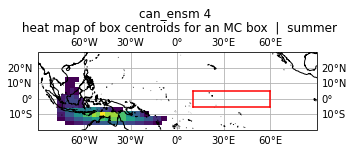

In [93]:
center = 180
proj = ccrs.PlateCarree(central_longitude=center)
fig = plt.figure(figsize=[5, 8])
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()



# ax.set_extent([minlon, maxlon, -45, 45], ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=proj, zorder=0)
ax.set_ylim([-20,30])
ax.set_xlim([-90,90]) #ax.set_xlim([-180,180])

#ax.scatter(hits_lons-cl, hits_lats, alpha=0.01)
pc = ax.pcolormesh(lons_un-center, lats_un, hits)
#ax.scatter(215-center, 0, color='red', s=3)

ax.plot([nn34[2]-center, nn34[3]-center],[nn34[0],nn34[0]], color='red')
ax.plot([nn34[2]-center, nn34[3]-center],[nn34[1],nn34[1]], color='red')

ax.plot([nn34[2]-center, nn34[2]-center],[nn34[0],nn34[1]], color='red')
ax.plot([nn34[3]-center, nn34[3]-center],[nn34[0],nn34[1]], color='red')

ax.set_title(f'{daatype} {first_ensm_inloop} \n heat map of box centroids for an MC box  |  {seas_names[s]}')

plt.savefig(f'mcbox_hits_{daatype}_{first_ensm_inloop}_{seas_names[s]}.png', dpi=300)